# 長距離伝送シミュレーションを行う

In [1]:
#import
import sys
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

sys.path.append('../')
from pyopt import modulate as md
from pyopt import transmission as tr
from pyopt.util import fft, ifft, save_pickle, load_pickle, sampling_signal

# 1. PRBS信号を伝送する

## 1.1 PRBS信号を生成する

In [2]:
N = 17  # PRBSの次数
itr = 1  # PRBSの繰り返し回数

In [3]:
bitsq = md.prbs(N=N, itr=itr)

#print('ビット列: ', bitsq[:128])
print('ビット長: ', bitsq.shape)

ビット長:  (131072,)


## 1.2 PRBS信号を変調する

In [4]:
form = 'RZ16QAM'  # 変調方式
n = 32  # 1シンボルあたりのサンプリング数[/symbol]
equalize = False  # 各シンボル数を均等にするか

In [5]:
mdl = md.Modulate(form=form, n=n, equalize=equalize)
modsq = mdl.transform(bitsq)

#print('シンボル列: ', modsq[:40])
print('シンボル長: ', modsq.shape)

rz16QAM modulation START
シンボル長:  (1048576,)


In [6]:
sampling = 2

modsq_sampled = sampling_signal(modsq, n, sampling)

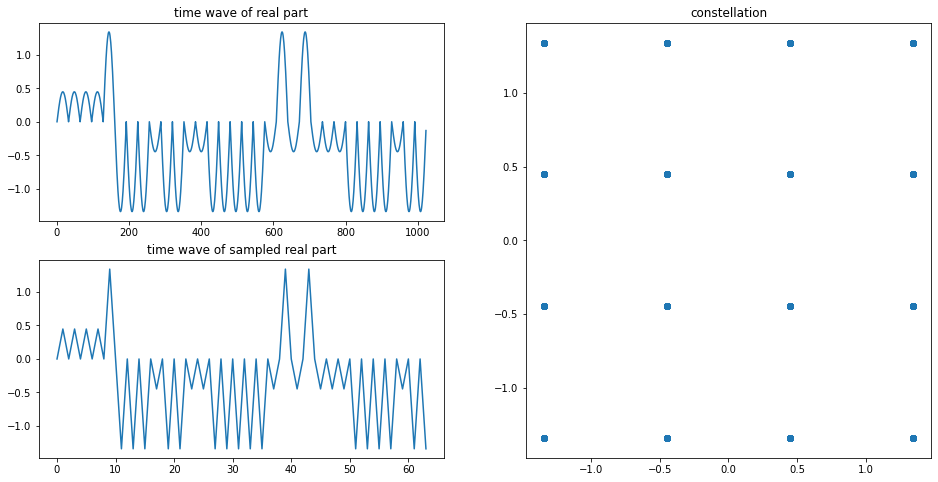

In [7]:
# 可視化 時間領域
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 3)
ax3 = fig.add_subplot(1, 2, 2)

ax1.plot(modsq[:n * 32].real)
ax1.set_title('time wave of real part')

ax2.plot(modsq_sampled[:sampling * 32].real)
ax2.set_title('time wave of sampled real part')

ax3.plot(modsq[int(n/2):: n].real, modsq[int(n/2):: n].imag, 'o')
ax3.set_title('constellation');

(1048576,)
(524288,)


Text(0.5, 1.0, 'frequency domain')

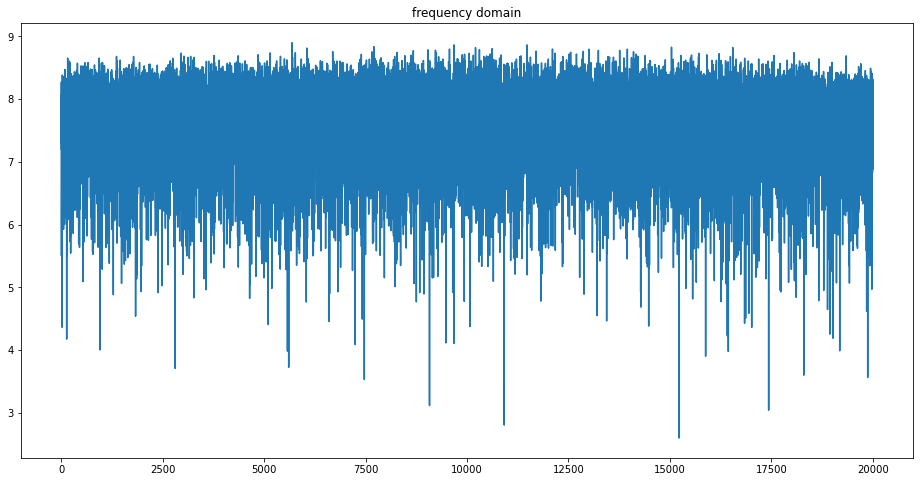

In [8]:
# 可視化 周波数領域
MODSQ = fft(modsq[::2])

print(modsq.shape)
print(MODSQ.shape)

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1)
a = 10000
ax.plot(np.log(abs(MODSQ[len(MODSQ) // 2 - a: len(MODSQ) // 2 + a])))
ax.set_title('frequency domain')

## 1.3 16QAM変調されたPRBS信号を伝送する

In [9]:
baudrate = 28  # ボーレート[GBaud]
PdBm = 1  # 平均入力光パワー[dBm]
Ledfa = 100  # EDFAスパン[km]
stepedfa = 30  # SSFMの繰り返し計算ステップ数
gamma = 1.4  # 非線形係数[/W/km]
D = 16  # 分散パラメータ[ps/nm/km]
Alpha = 0.16  # 伝送損失[dB/km]
NF = 4  # ASE雑音指数[dB]

Lmax = 500  # 伝送距離[km]
ase = True  # ASE雑音を考慮するか

In [10]:
sgnl = tr.Signal(seq=modsq, form=form, n=n, baudrate=baudrate, PdBm=PdBm, Ledfa=Ledfa, stepedfa=stepedfa,
                           gamma=gamma, D=D, Alpha=Alpha, NF=NF)
sgnl.transmission(Lmax=Lmax, ase=ase)

  0%|                                                                                                                                                                                                            | 0/5 [00:27<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
signal_in = sgnl.signal['x_0']
signal_in_sampled = signal_in[int(n/2)::n]
signal = sgnl.signal['x_500']
signal_sampled = signal[int(n/2)::n]
signal_lc = sgnl.linear_compensation(Lmax, sgnl.signal['x_500'])
signal_lc_sampled = signal_lc[int(n/2)::n]

print('位相回転量(理論値): ', sgnl.phase_rotation_theo(Lmax))
print('位相回転量(シミュレーション値): ', sgnl.phase_rotation_simu(Lmax, signal_lc_sampled))
print('EVM(補償無し): ', sgnl.cal_evm(Lmax, signal_sampled))
print('EVM(100%線形補償): ', sgnl.cal_evm(Lmax, signal_lc_sampled))
print('EVM(100%線形補償+位相回転補償): ', sgnl.cal_evm_pr(Lmax, signal_lc_sampled))
print('BER(100%線形補償): ', sgnl.cal_ber(Lmax, signal_lc_sampled))
print('Q値(100%線形補償): ', sgnl.cal_qfac(Lmax, signal_lc_sampled))

In [ ]:
# 可視化 時間領域
fig = plt.figure(figsize=(16, 24))
ax1 = fig.add_subplot(6, 2, 1)
ax2 = fig.add_subplot(6, 2, 3)
ax3 = fig.add_subplot(3, 2, 2)
ax4 = fig.add_subplot(6, 2, 5)
ax5 = fig.add_subplot(6, 2, 7)
ax6 = fig.add_subplot(3, 2, 4)
ax7 = fig.add_subplot(6, 2, 9)
ax8 = fig.add_subplot(6, 2, 11)
ax9 = fig.add_subplot(3, 2, 6)

ax1.plot(signal_in[:32 * n].real)
ax1.set_title('time wave of real part L=0km')
ax2.plot(signal_in[:32 * n].imag)
ax2.set_title('time wave of imag part L=0km')
ax3.plot(signal_in_sampled.real, signal_in_sampled.imag, 'o')
ax3.set_title('constellation L=0km')

ax4.plot(signal[:32 * n].real)
ax4.set_title('time wave of real part L=500km')
ax5.plot(signal[:32 * n].imag)
ax5.set_title('time wave of imag part L=500km')
ax6.plot(signal_sampled.real, signal_sampled.imag, 'o')
ax6.set_title('constellation L=500km')

ax7.plot(signal_lc[:32 * n].real)
ax7.set_title('time wave of real part L=500km 100%linear comp.')
ax8.plot(signal_lc[:32 * n].imag)
ax8.set_title('time wave of imag part L=500km 100%linear comp.')
ax9.plot(signal_lc_sampled.real, signal_lc_sampled.imag, 'o')
ax9.set_title('constellation L=500km 100%linear comp.');

In [ ]:
#可視化 周波数領域
signal_sampled = sampling_signal(signal, n, 16)
SIGNAL = fft(signal_sampled)

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.log(abs(SIGNAL)))
ax.set_title('frequency domain')

## PRBS信号 伝送&dataframe追加

In [25]:
def prbs_transmission(PdBm, N):
    #N = 17  # PRBSの次数
    itr = 1  # PRBSの繰り返し回数
    form = 'RZ16QAM'  # 変調方式
    n = 32  # 1シンボルあたりのサンプリング数[/symbol]
    equalize = False  # 各シンボル数を均等にするか
    baudrate = 28  # ボーレート[GBaud]
    #PdBm = 1  # 平均入力光パワー[dBm]
    Ledfa = 100  # EDFAスパン[km]
    stepedfa = 30  # SSFMの繰り返し計算ステップ数
    gamma = 1.4  # 非線形係数[/W/km]
    D = 16  # 分散パラメータ[ps/nm/km]
    Alpha = 0.16  # 伝送損失[dB/km]
    NF = 4  # ASE雑音指数[dB]
    Lmax = 2500  # 伝送距離[km]
    ase = True  # ASE雑音を考慮するか

    df_dir = '../data/input/prbs.csv'
    if os.path.exists(df_dir):
        df = pd.read_csv(df_dir, index_col=0)
    else:
        cols = ['N', 'itr', 'form', 'n', 'equalize', 'baudrate', 'PdBm', 'Ledfa', 'stepedfa', 'gamma', 'D', 'Alpha', 'NF', 'Lmax', 'ase', 'data_path']
        df = pd.DataFrame(index=[], columns=cols)

    condition = (df['N']==N) & (df['itr']==itr) & (df['form']==form) & (df['n']==n) & (df['equalize']==equalize) & (df['baudrate']==baudrate) & \
                         (df['PdBm']==PdBm) & (df['Ledfa']==Ledfa) & (df['stepedfa']==stepedfa) & (df['gamma']==gamma) & (df['D']==D) & \
                         (df['Alpha']==Alpha) & (df['NF']==NF) & (df['ase']==ase)
    if sum(condition) > 0:
        index = df[condition].index[0]
        if df['Lmax'][index] >= Lmax:
            print('指定された条件の伝送データはすでに存在します')
        else:
            data_path = df['data_path'][index]
            sgnl = load_pickle(data_path)
            sgnl.transmission(Lmax=Lmax, ase=ase)
            save_pickle(sgnl, data_path)

            df.loc[index, 'Lmax'] = Lmax
            df.to_csv(df_dir)
    else:
        data_path = '../data/input/prbs/prbs_' + str(len(df)).zfill(10) + '.pickle'
        bitsq = md.prbs(N=N, itr=itr)
        mdl = md.Modulate(form=form, n=n, equalize=equalize)
        modsq = mdl.transform(bitsq)
        sgnl = tr.Signal(seq=modsq, form=form, n=n, baudrate=baudrate, PdBm=PdBm, Ledfa=Ledfa, stepedfa=stepedfa,
                                   gamma=gamma, D=D, Alpha=Alpha, NF=NF)
        sgnl.transmission(Lmax=Lmax, ase=ase)
        save_pickle(sgnl, data_path)

        sr = pd.Series([N, itr, form, n, equalize, baudrate, PdBm, Ledfa, stepedfa, gamma, D, Alpha, NF, Lmax, ase, data_path], index=df.columns)
        df = df.append(sr, ignore_index=True)
        df.to_csv(df_dir)

In [26]:
for PdBm in [1]:
    prbs_transmission(PdBm, 13)

rz16QAM modulation START


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [04:41<00:00, 11.27s/it]


# 2. Random信号を伝送する

## 2.1 Random信号を生成する

In [ ]:
seed = 1234  # 乱数シード
bit_num = 128  # ビット長を指定

In [ ]:
np.random.seed(seed=seed)
ransq = np.random.randint(0, 2, bit_num)

print('ビット列: ', ransq)
print('ビット長: ', ransq.shape)

## Random信号 伝送&dataframe追加

In [10]:
def random_transmission(PdBm):
    seed = 1234  # 乱数シード
    bit_num = 50000  # ビット長を指定
    form = 'RZ16QAM'  # 変調方式
    n = 32  # 1シンボルあたりのサンプリング数[/symbol]
    equalize = False  # 各シンボル数を均等にするか
    baudrate = 28  # ボーレート[GBaud]
    # PdBm = 1  # 平均入力光パワー[dBm]
    Ledfa = 100  # EDFAスパン[km]
    stepedfa = 30  # SSFMの繰り返し計算ステップ数
    gamma = 1.4  # 非線形係数[/W/km]
    D = 16  # 分散パラメータ[ps/nm/km]
    Alpha = 0.16  # 伝送損失[dB/km]
    NF = 4  # ASE雑音指数[dB]
    Lmax = 5000  # 伝送距離[km]
    ase = True  # ASE雑音を考慮するか

    df_dir = '../data/input/random.csv'
    if os.path.exists(df_dir):
        df = pd.read_csv(df_dir, index_col=0)
    else:
        cols = ['seed', 'bit_num', 'form', 'n', 'equalize', 'baudrate', 'PdBm', 'Ledfa', 'stepedfa', 'gamma', 'D', 'Alpha', 'NF', 'Lmax', 'ase', 'data_path']
        df = pd.DataFrame(index=[], columns=cols)

    condition = (df['seed']==seed) & (df['bit_num']==bit_num) & (df['form']==form) & (df['n']==n) & (df['equalize']==equalize) & (df['baudrate']==baudrate) & \
                         (df['PdBm']==PdBm) & (df['Ledfa']==Ledfa) & (df['stepedfa']==stepedfa) & (df['gamma']==gamma) & (df['D']==D) & \
                         (df['Alpha']==Alpha) & (df['NF']==NF) & (df['ase']==ase)
    if sum(condition) > 0:
        index = df[condition].index[0]
        if df['Lmax'][index] >= Lmax:
            print('指定された条件の伝送データはすでに存在します')
        else:
            data_path = df['data_path'][index]
            sgnl = load_pickle(data_path)
            sgnl.transmission(Lmax=Lmax, ase=ase)
            save_pickle(sgnl, data_path)

            df.loc[index, 'Lmax'] = Lmax
            df.to_csv(df_dir)
    else:
        data_path = '../data/input/random/random_' + str(len(df)).zfill(10) + '.pickle'
        np.random.seed(seed=seed)
        ransq = np.random.randint(0, 2, bit_num)
        mdl = md.Modulate(form=form, n=n, equalize=equalize)
        modsq = mdl.transform(ransq)
        sgnl = tr.Signal(seq=modsq, form=form, n=n, baudrate=baudrate, PdBm=PdBm, Ledfa=Ledfa, stepedfa=stepedfa,
                                   gamma=gamma, D=D, Alpha=Alpha, NF=NF)
        sgnl.transmission(Lmax=Lmax, ase=ase)
        save_pickle(sgnl, data_path)

        sr = pd.Series([seed, bit_num, form, n, equalize, baudrate, PdBm, Ledfa, stepedfa, gamma, D, Alpha, NF, Lmax, ase, data_path], index=df.columns)
        df = df.append(sr, ignore_index=True)
        df.to_csv(df_dir)


In [12]:
for PdBm in [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]:
    random_transmission(PdBm)

rz16QAM modulation START


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [42:49<00:00, 51.39s/it]


rz16QAM modulation START


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [43:29<00:00, 52.18s/it]


指定された条件の伝送データはすでに存在します
指定された条件の伝送データはすでに存在します
指定された条件の伝送データはすでに存在します
指定された条件の伝送データはすでに存在します
指定された条件の伝送データはすでに存在します
指定された条件の伝送データはすでに存在します
指定された条件の伝送データはすでに存在します
rz16QAM modulation START


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [42:46<00:00, 51.34s/it]


rz16QAM modulation START


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [42:51<00:00, 51.44s/it]


# 3. Image信号を伝送する

## 3.1 Image信号を生成する

In [ ]:
target_dir = 'train'
step = 10  # (768, 1024) ---> (76, 102)
image_number = 9
ebtb = False  # 8B10Bを行うか

In [ ]:
image_dir = '../data/image/'
image_path_list = sorted(glob.glob(os.path.join(image_dir + target_dir, '*.jpg')))
image_path = image_path_list[image_number]
print(image_path)

In [ ]:
img = Image.open(image_path)
img_array = np.array(img)
print('画像サイズ: ', img_array.shape)

fig = plt.figure(figsize=(9, 6))
plt.imshow(img);

In [ ]:
imgsq = img_array[::step, ::step].reshape(-1)

print('配列: ', imgsq)
print('配列長: ', imgsq.shape)

In [ ]:
if ebtb:
    imgsq_binary = md.eightb_tenb(imgsq)
else:
    imgsq_binary = md.image_to_binary(imgsq)

print('ビット列: ', imgsq_binary[:128])
print('ビット長: ', imgsq_binary.shape)

## Image信号 伝送&dataframe追加

In [2]:
def image_transmission(image_number, PdBm):
    target_dir = 'train'
    step = 10  # =10 ---> (768, 1024) ---> (76, 102)
    #image_number = 4
    ebtb = True  # 8B10Bを行うか
    form = 'RZ16QAM'  # 変調方式
    n = 32  # 1シンボルあたりのサンプリング数[/symbol]
    equalize = False  # 各シンボル数を均等にするか
    baudrate = 28  # ボーレート[GBaud]
    #PdBm = 1  # 平均入力光パワー[dBm]
    Ledfa = 100  # EDFAスパン[km]
    stepedfa = 30  # SSFMの繰り返し計算ステップ数
    gamma = 1.4  # 非線形係数[/W/km]
    D = 16  # 分散パラメータ[ps/nm/km]
    Alpha = 0.16  # 伝送損失[dB/km]
    NF = 4  # ASE雑音指数[dB]
    Lmax = 10000  # 伝送距離[km]
    ase = True  # ASE雑音を考慮するか

    df_dir = '../data/input/image.csv'
    if os.path.exists(df_dir):
        df = pd.read_csv(df_dir, index_col=0)
    else:
        cols = ['target_dir', 'step', 'image_number', 'ebtb',
                    'form', 'n', 'equalize', 'baudrate', 'PdBm', 'Ledfa', 'stepedfa', 'gamma', 'D', 'Alpha', 'NF', 'Lmax', 'ase', 'data_path', 'image_path']
        df = pd.DataFrame(index=[], columns=cols)

    condition = (df['target_dir']==target_dir) & (df['step']==step) & (df['image_number']==image_number) & (df['ebtb']==ebtb) & (df['form']==form) & \
                         (df['n']==n) & (df['equalize']==equalize) & (df['baudrate']==baudrate) & (df['PdBm']==PdBm) & (df['Ledfa']==Ledfa) & \
                         (df['stepedfa']==stepedfa) & (df['gamma']==gamma) & (df['D']==D) & (df['Alpha']==Alpha) & (df['NF']==NF) & (df['ase']==ase)
    if sum(condition) > 0:
        index = df[condition].index[0]
        if df['Lmax'][index] >= Lmax:
            print('指定された条件の伝送データはすでに存在します')
        else:
            data_path = df['data_path'][index]
            sgnl = load_pickle(data_path)
            sgnl.transmission(Lmax=Lmax, ase=ase)
            save_pickle(sgnl, data_path)

            df.loc[index, 'Lmax'] = Lmax
            df.to_csv(df_dir)
    else:        
        data_path = '../data/input/image/image_' + str(len(df)).zfill(10) + '.pickle'
        image_dir = '../data/image/'
        image_path_list = sorted(glob.glob(os.path.join(image_dir + target_dir, '*.jpg')))
        image_path = image_path_list[image_number]
        img = Image.open(image_path)
        img_array = np.array(img)
        imgsq = img_array[::step, ::step].reshape(-1)
        if ebtb:
            imgsq_binary = md.eightb_tenb(imgsq)
        else:
            imgsq_binary = md.image_to_binary(imgsq)

        mdl = md.Modulate(form=form, n=n, equalize=equalize)
        modsq = mdl.transform(imgsq_binary)
        sgnl = tr.Signal(seq=modsq, form=form, n=n, baudrate=baudrate, PdBm=PdBm, Ledfa=Ledfa, stepedfa=stepedfa,
                                   gamma=gamma, D=D, Alpha=Alpha, NF=NF)
        sgnl.transmission(Lmax=Lmax, ase=ase)
        save_pickle(sgnl, data_path)

        sr = pd.Series([target_dir, step, image_number, ebtb,
                                   form, n, equalize, baudrate, PdBm, Ledfa, stepedfa, gamma, D, Alpha, NF, Lmax, ase, data_path, image_path], index=df.columns)
        df = df.append(sr, ignore_index=True)
        df.to_csv(df_dir)

In [3]:
#for PdBm in [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]:
image_transmission(9, 1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21321/21321 [00:02<00:00, 10009.94it/s]


rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [7:27:01<00:00, 268.22s/it]


In [16]:
def cal_evm(input_signal, output_signal):
    symbol, index, inverse, counts = np.unique(input_signal, return_index=True, return_inverse=True, return_counts=True)

    t_sum = 0
    for i in range(len(index)):
        t_sum += abs(input_signal[index[i]])
    mean = t_sum / len(index)

    tmp = 0
    for i in range(len(output_signal)):
        tmp += abs(output_signal[i] - input_signal[i]) ** 2# / abs(input_signal[i]) ** 2
    evm = np.sqrt(tmp / len(output_signal)) / mean * 100
    return evm

def cal_evm_min(input_signal, output_signal):
    symbol, index, inverse, counts = np.unique(input_signal, return_index=True, return_inverse=True, return_counts=True)

    t_sum = 0
    for i in range(len(index)):
        t_sum += abs(input_signal[index[i]])
    mean = t_sum / len(index)

    evm_min = 200
    i_min = 0
    for i in range(360):
        signal = output_signal * np.exp(1j * i * np.pi/180)
        tmp = 0
        for j in range(len(output_signal)):
            tmp += abs(signal[j] - input_signal[j]) ** 2# / abs(input_signal[j]) ** 2
        evm = np.sqrt(tmp / len(output_signal)) / mean * 100
        if evm < evm_min:
            evm_min = evm
            i_min = i
    return evm_min, i_min

In [4]:
def display_constellation_color(signal, seq):
    symbol, inverse, counts = np.unique(seq, return_inverse=True, return_counts=True)
    
    cm = plt.get_cmap('rainbow', 16)
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot()
    for i in range(len(symbol)):
        line, = ax.plot(signal[seq == symbol[i]].real, signal[seq == symbol[i]].imag, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]], label=str(counts[i]))
    lim = 150000
    ax.set_xlim((-lim, lim))
    ax.set_ylim((-lim, lim))
    ax.xaxis.set_tick_params(direction='in')
    ax.yaxis.set_tick_params(direction='in')
    plt.tick_params(labelbottom=False,
                    labelleft=False,
                    labelright=False,
                    labeltop=False)
    plt.tick_params(bottom=False,
                    left=False,
                    right=False,
                    top=False)
    plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95)
    plt.show()

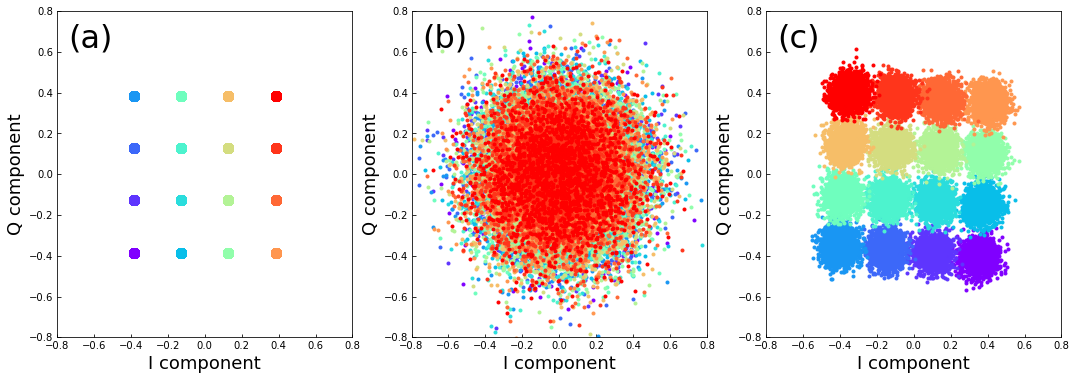

In [81]:
prbs = load_pickle('../data/input/prbs/prbs_0000000011.pickle')
lc = prbs.linear_compensation(5000, prbs.signal['x_5000'])
prbs_max = max(abs(prbs.signal['x_5000']))

seq = prbs.seq[16::32]
symbol, inverse, counts = np.unique(seq, return_inverse=True, return_counts=True)

cm = plt.get_cmap('rainbow', 16)
fig = plt.figure(figsize=(18, 6))
ax0 = fig.add_subplot(1, 3, 1)
ax1 = fig.add_subplot(1, 3, 2)
ax2 = fig.add_subplot(1, 3, 3)
for i in range(len(symbol)):
    ax0.plot(prbs.signal['x_0'][16::32][seq == symbol[i]].real / prbs_max, prbs.signal['x_0'][16::32][seq == symbol[i]].imag / prbs_max, 'o', markersize=10, color=[cm(i)[0], cm(i)[1], cm(i)[2]])
    ax1.plot(prbs.signal['x_5000'][16::32][seq == symbol[i]].real / prbs_max, prbs.signal['x_5000'][16::32][seq == symbol[i]].imag / prbs_max, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]])
    ax2.plot(lc[16::32][seq == symbol[i]].real / prbs_max, lc[16::32][seq == symbol[i]].imag / prbs_max, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]])
ax0.text(-0.74, 0.62, '(a)', color='black', fontsize=32)
ax1.text(-0.74, 0.62, '(b)', color='black', fontsize=32)
ax2.text(-0.74, 0.62, '(c)', color='black', fontsize=32)
lim = 0.8
ax0.set_xlim((-lim, lim))
ax0.set_ylim((-lim, lim))
ax1.set_xlim((-lim, lim))
ax1.set_ylim((-lim, lim))
ax2.set_xlim((-lim, lim))
ax2.set_ylim((-lim, lim))
ax0.set_xlabel('I component', fontsize=18)
ax0.set_ylabel('Q component', fontsize=18)
ax1.set_xlabel('I component', fontsize=18)
ax1.set_ylabel('Q component', fontsize=18)
ax2.set_xlabel('I component', fontsize=18)
ax2.set_ylabel('Q component', fontsize=18)
ax0.xaxis.set_tick_params(direction='in')
ax0.yaxis.set_tick_params(direction='in')
ax1.xaxis.set_tick_params(direction='in')
ax1.yaxis.set_tick_params(direction='in')
ax2.xaxis.set_tick_params(direction='in')
ax2.yaxis.set_tick_params(direction='in')
plt.show()

In [9]:
def load_image(target_dir, image_number):
    image_dir = '../data/image/'
    image_path_list = sorted(glob.glob(os.path.join(image_dir + target_dir, '*.jpg')))
    image_path = image_path_list[image_number]
    img = Image.open(image_path)
    return img

In [42]:
img = load_image('train', 9)
wo8b10b = load_pickle('../data/input/image/image_0000000143.pickle')
wo8b10b_lc = wo8b10b.linear_compensation(5000, wo8b10b.signal['x_5000'])
wo8b10b_lc = wo8b10b_lc * np.exp(1j * 45 * np.pi / 180)
pr_theo = wo8b10b.phase_rotation_theo(5000)
wo8b10b_lc_pr = wo8b10b_lc * np.exp(1j * pr_theo * np.pi / 180)
w8b10b = load_pickle('../data/input/image/image_0000000144.pickle')
w8b10b_lc = w8b10b.linear_compensation(5000, w8b10b.signal['x_5000'])
pr_theo = w8b10b.phase_rotation_theo(5000)
w8b10b_lc_pr = w8b10b_lc * np.exp(1j * pr_theo * np.pi / 180)

evm1 = cal_evm(wo8b10b.signal['x_0'][16::32], wo8b10b_lc_pr[16::32])
evm2 = cal_evm(w8b10b.signal['x_0'][16::32], w8b10b_lc_pr[16::32])

seq1 = wo8b10b.seq[16::32]
symbol1, inverse1, counts1 = np.unique(seq1, return_inverse=True, return_counts=True)
seq2 = w8b10b.seq[16::32]
symbol2, inverse2, counts2 = np.unique(seq2, return_inverse=True, return_counts=True)
_max = max(max(abs(wo8b10b_lc_pr)), max(abs(w8b10b_lc_pr)))

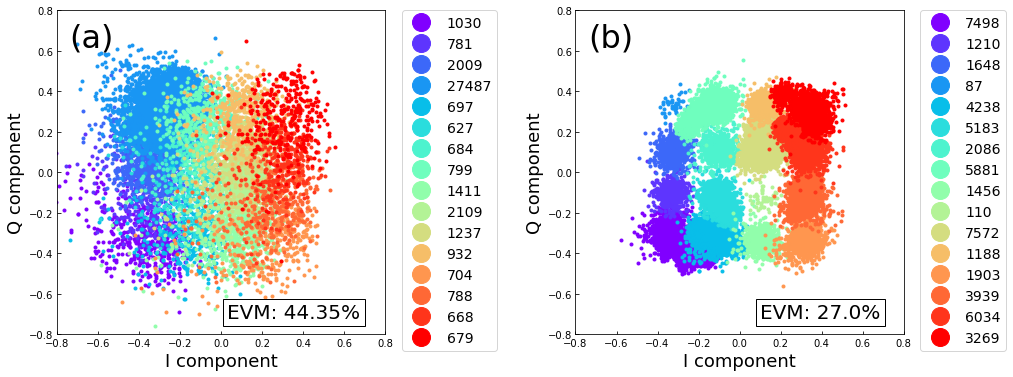

In [57]:
cm = plt.get_cmap('rainbow', 16)
boxdic = {
        'facecolor' : 'white',
        'edgecolor' : 'black',
        'linewidth' : 1}
fig = plt.figure(figsize=(12, 6))
#ax0 = fig.add_subplot(1, 3, 1)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.set_position([0.05, 0.9, 0.38, 0.75])
ax2.set_position([0.65, 0.9, 0.38, 0.75])
#ax0.imshow(img)
for i in range(len(symbol)):
    ax1.plot(wo8b10b_lc_pr[16::32][seq1 == symbol[i]][::2].real / _max, wo8b10b_lc_pr[16::32][seq1 == symbol[i]][::2].imag / _max, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]], label=str(counts1[i]))
    ax2.plot(w8b10b_lc_pr[16::32][seq2 == symbol[i]][::2].real / _max, w8b10b_lc_pr[16::32][seq2 == symbol[i]][::2].imag /_max, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]], label=str(counts2[i]))
#ax0.text(0, -100, '(a)', color='black', fontsize=32)
ax1.text(-0.74, 0.62, '(a)', color='black', fontsize=32)
ax2.text(-0.74, 0.62, '(b)', color='black', fontsize=32)
ax1.text(0.03, -0.72, 'EVM: ' + str(round(evm1, 2)) + '%', color='black', fontsize=20, bbox=boxdic)
ax2.text(0.10, -0.72, 'EVM: ' + str(round(evm2)) + '%', color='black', fontsize=20, bbox=boxdic)
ax1.legend(fontsize=14, markerscale=6, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax2.legend(fontsize=14, markerscale=6, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
lim = 0.8
ax1.set_xlim((-lim, lim))
ax1.set_ylim((-lim, lim))
ax2.set_xlim((-lim, lim))
ax2.set_ylim((-lim, lim))
ax1.set_xlabel('I component', fontsize=18)
ax1.set_ylabel('Q component', fontsize=18)
ax2.set_xlabel('I component', fontsize=18)
ax2.set_ylabel('Q component', fontsize=18)
ax1.xaxis.set_tick_params(direction='in')
ax1.yaxis.set_tick_params(direction='in')
ax2.xaxis.set_tick_params(direction='in')
ax2.yaxis.set_tick_params(direction='in')
plt.show()